In [2]:
!pip install --pre pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 74.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flask to determine which version is compatible with other requirements. This could take a while.
     ━━━

In [3]:
%pip install -q pycaret psycopg2-binary pandas sqlalchemy
import psycopg2
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import mysql.connector
import psycopg2
from pycaret.anomaly import *
from pycaret.clustering import *

def get_combined_iris_data():
    # ================== KONEKSI DATABASE ==================
    # Konfigurasi MySQL (sepal data)
    mysql_config = {
        'host': 'mysql-e757f9e-mysql21-170.k.aivencloud.com',
        'database': 'defaultdb',
        'user': 'avnadmin',
        'password': 'AVNS_SBq0W10F8cX8a_k6Rmk',
        'port': 14185
    }

    # Konfigurasi PostgreSQL (petal data)
    postgresql_config = {
        'host': 'pg-28b788a6-postgresql21-170.k.aivencloud.com',
        'database': 'defaultdb',
        'user': 'avnadmin',
        'password': 'AVNS_0SEae8-ab3bmh-ETzmr',
        'port': 13844
    }

    # ================== AMBIL DATA ==================
    try:
        # Ambil data sepal dari MySQL
        mysql_conn = mysql.connector.connect(**mysql_config)
        sepal_df = pd.read_sql("SELECT id, class, sepal_length, sepal_width FROM iris_sepal_data", mysql_conn)
        mysql_conn.close()
        print("✅ Data sepal berhasil diambil dari MySQL")
    except Exception as e:
        print(f"❌ MySQL Error: {e}")
        return pd.DataFrame()

    try:
        # Ambil data petal dari PostgreSQL
        postgresql_conn = psycopg2.connect(**postgresql_config)
        petal_df = pd.read_sql("SELECT id, class, petal_length, petal_width FROM petal_data", postgresql_conn)
        postgresql_conn.close()
        print("✅ Data petal berhasil diambil dari PostgreSQL")
    except Exception as e:
        print(f"❌ PostgreSQL Error: {e}")
        return pd.DataFrame()

    # ================== GABUNGKAN DATA ==================
    if not sepal_df.empty and not petal_df.empty:
        combined_data = pd.merge(sepal_df, petal_df, on=['id', 'class'], how='inner')
        print(f"✅ Data berhasil digabungkan. Total records: {len(combined_data)}")
        return combined_data
    else:
        print("❌ Error: Tidak bisa menggabungkan data dari kedua database")
        return pd.DataFrame()

def detect_outliers_knn(data):
    try:
        # Hanya gunakan kolom numerik untuk outlier detection
        numeric_data = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

        # Setup PyCaret untuk anomaly detection
        exp_ano = setup(numeric_data, normalize=True, session_id=123, verbose=False, silent=True)

        # Buat model K-NN untuk outlier detection
        knn_model = create_model('knn')

        # Assign outliers
        knn_results = assign_model(knn_model)

        # Gabungkan dengan data original
        final_data = data.copy()
        final_data['Anomaly_KNN'] = knn_results['Anomaly'].astype(int)  # Convert to int for Power BI
        final_data['Anomaly_Score_KNN'] = knn_results['Anomaly_Score']

        print("✅ Outlier detection dengan K-NN selesai")
        return final_data
    except Exception as e:
        print(f"❌ Outlier Detection K-NN Error: {e}")
        # Return data dengan kolom anomaly default jika gagal
        data['Anomaly_KNN'] = 0
        data['Anomaly_Score_KNN'] = 0.0
        return data

def detect_outliers_abod(data):
    try:
        # Hanya gunakan kolom numerik untuk outlier detection
        numeric_data = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

        # Setup PyCaret untuk anomaly detection
        exp_ano = setup(numeric_data, normalize=True, session_id=123, verbose=False, silent=True)

        # Buat model ABOD untuk outlier detection
        abod_model = create_model('abod')

        # Assign outliers
        abod_results = assign_model(abod_model)

        # Gabungkan dengan data original
        final_data = data.copy()
        final_data['Anomaly_ABOD'] = abod_results['Anomaly'].astype(int)  # Convert to int for Power BI
        final_data['Anomaly_Score_ABOD'] = abod_results['Anomaly_Score']

        print("✅ Outlier detection dengan ABOD selesai")
        return final_data, abod_results
    except Exception as e:
        print(f"❌ Outlier Detection ABOD Error: {e}")
        # Return data dengan kolom anomaly default jika gagal
        data['Anomaly_ABOD'] = 0
        data['Anomaly_Score_ABOD'] = 0.0
        return data, pd.DataFrame()

def perform_clustering_kmeans(data):
    try:
        # Hanya gunakan kolom numerik untuk clustering
        numeric_data = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

        # Setup PyCaret untuk clustering
        exp_clu = setup(numeric_data, normalize=True, session_id=123, verbose=False, silent=True)

        # Buat model K-Means clustering
        kmeans_model = create_model('kmeans', num_clusters=3)  # 3 cluster untuk iris

        # Assign clusters
        kmeans_results = assign_model(kmeans_model)

        # Gabungkan dengan data original
        final_data = data.copy()
        final_data['Cluster'] = kmeans_results['Cluster'].astype(str)  # Convert to string for Power BI

        print("✅ Clustering dengan K-Means selesai")
        return final_data
    except Exception as e:
        print(f"❌ Clustering Error: {e}")
        # Return data dengan cluster default jika gagal
        data['Cluster'] = '0'
        return data

def display_abod_results(final_data, abod_outliers):
    """Menampilkan hasil detail dari ABOD outlier detection"""

    print("\n" + "="*60)
    print("📊 DETAIL HASIL ABOD OUTLIER DETECTION")
    print("="*60)

    # Filter hanya data yang terdeteksi sebagai outlier oleh ABOD
    abod_outlier_data = final_data[final_data['Anomaly_ABOD'] == 1]

    if not abod_outlier_data.empty:
        print(f"🔴 Total outlier terdeteksi oleh ABOD: {len(abod_outlier_data)}")
        print("\n📈 Distribusi outlier berdasarkan class:")
        print(abod_outlier_data['class'].value_counts())

        print("\n📈 Distribusi outlier berdasarkan cluster:")
        print(abod_outlier_data['Cluster'].value_counts())

        print("\n🏆 Top 5 outlier dengan score tertinggi:")
        top_outliers = abod_outlier_data.nlargest(5, 'Anomaly_Score_ABOD')[
            ['id', 'class', 'Cluster', 'Anomaly_Score_ABOD',
             'sepal_length', 'sepal_width', 'petal_length', 'petal_width']
        ]
        print(top_outliers.to_string(index=False))

        print("\n📋 Statistik Anomaly Score ABOD:")
        print(f"   Rata-rata score: {abod_outlier_data['Anomaly_Score_ABOD'].mean():.4f}")
        print(f"   Score tertinggi: {abod_outlier_data['Anomaly_Score_ABOD'].max():.4f}")
        print(f"   Score terendah: {abod_outlier_data['Anomaly_Score_ABOD'].min():.4f}")
        print(f"   Standar deviasi: {abod_outlier_data['Anomaly_Score_ABOD'].std():.4f}")

        # Tampilkan perbandingan dengan K-NN
        common_outliers = len(abod_outlier_data[abod_outlier_data['Anomaly_KNN'] == 1])
        unique_abod_outliers = len(abod_outlier_data) - common_outliers

        print(f"\n🔁 Perbandingan dengan K-NN:")
        print(f"   Outlier yang terdeteksi oleh kedua metode: {common_outliers}")
        print(f"   Outlier yang hanya terdeteksi oleh ABOD: {unique_abod_outliers}")

    else:
        print("✅ Tidak ada outlier yang terdeteksi oleh ABOD")

    print("\n" + "="*60)

# ================== EKSEKUSI UTAMA ==================
print("Menggabungkan data dari MySQL dan PostgreSQL...")
iris_data = get_combined_iris_data()

if not iris_data.empty:
    print("Deteksi outlier dengan K-NN...")
    outlier_results_knn = detect_outliers_knn(iris_data)

    print("Deteksi outlier dengan ABOD...")
    outlier_results_abod, abod_raw_results = detect_outliers_abod(iris_data)

    # Gabungkan hasil dari kedua metode outlier detection
    combined_outlier_results = outlier_results_knn.copy()
    combined_outlier_results['Anomaly_ABOD'] = outlier_results_abod['Anomaly_ABOD']
    combined_outlier_results['Anomaly_Score_ABOD'] = outlier_results_abod['Anomaly_Score_ABOD']

    print("Clustering dengan K-Means...")
    final_results = perform_clustering_kmeans(combined_outlier_results)

    print("✅ Tugas selesai! Data ready untuk visualization")
    print(f"Jumlah data: {len(final_results)}")
    print(f"Kolom: {list(final_results.columns)}")

    # Hitung statistik untuk perbandingan metode
    knn_outliers = final_results['Anomaly_KNN'].sum()
    abod_outliers = final_results['Anomaly_ABOD'].sum()

    print(f"\n📊 PERBANDINGAN METODE OUTLIER DETECTION:")
    print(f"Outlier terdeteksi oleh K-NN: {knn_outliers}")
    print(f"Outlier terdeteksi oleh ABOD: {abod_outliers}")

    # Tampilkan hasil detail ABOD
    display_abod_results(final_results, abod_outliers)

    # Simpan hasil ke CSV untuk analisis lebih lanjut
    try:
        final_results.to_csv('iris_analysis_results.csv', index=False)
        print(f"\n💾 Hasil analisis disimpan sebagai 'iris_analysis_results.csv'")

        # Simpan hanya outlier ABOD untuk analisis detail
        abod_outliers_data = final_results[final_results['Anomaly_ABOD'] == 1]
        if not abod_outliers_data.empty:
            abod_outliers_data.to_csv('abod_outliers_detail.csv', index=False)
            print(f"💾 Detail outlier ABOD disimpan sebagai 'abod_outliers_detail.csv'")

    except Exception as e:
        print(f"⚠️  Error menyimpan file: {e}")

    # Return final results untuk Power BI
    final_results

else:
    print("❌ Gagal mengambil data dari database")
    # Return dataframe kosong dengan struktur yang diharapkan
    pd.DataFrame(columns=['id', 'class', 'sepal_length', 'sepal_width',
                         'petal_length', 'petal_width', 'Anomaly_KNN', 'Anomaly_Score_KNN',
                         'Anomaly_ABOD', 'Anomaly_Score_ABOD', 'Cluster'])

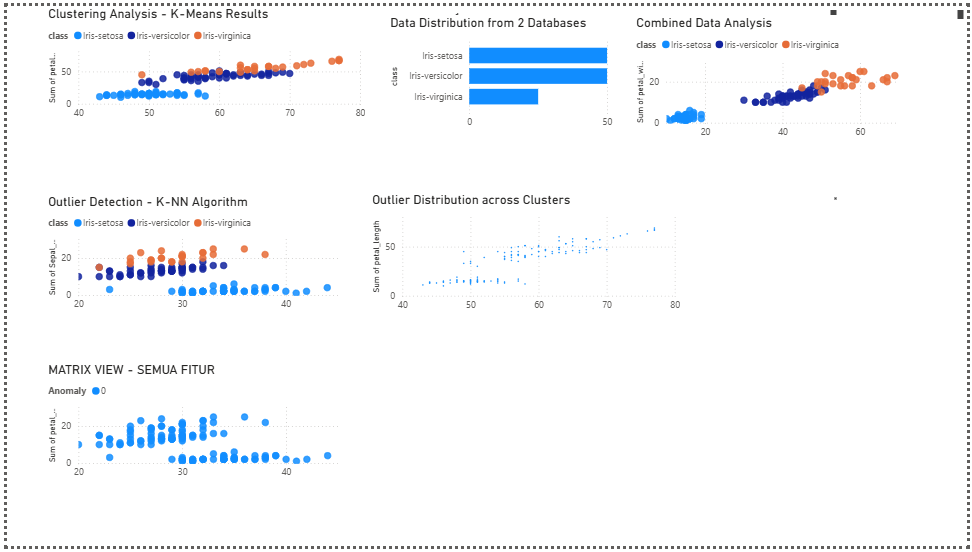